In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import time
import gc
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
mydata=pd.read_csv('jw5.25testv2.csv')

In [3]:
mydata.shape

(843507, 40)

In [61]:
mydata.head()

,Unnamed: 0,fiscal_year_value,opco,branch_code,cust_id,cust_name,CITY,STATE,POSTAL,JOBTITLE,...,zone,zone_desc,division,division_desc,concept,concept_desc,segment_group,consolidate_msa1,consolidate_msa2,uniqueID
0,0,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35283,OFF0167,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALSENIOR ADMINISTRATIVE ASS..."
1,1,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK"
2,2,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK"
3,3,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK"
4,4,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK"


Modify BLS data (mapping file with OES at MSA level, inner join with matching job titles. Mapping file (after manual categorization and normalization)

In [4]:

def blsclean():
    #input=bls
    # cleanse - where Hmean Hmedian has no number
    # mapping job_desc with occ_title
    
    df=pd.read_csv('MSA_M2020.csv', usecols= ['AREA_TITLE','OCC_TITLE', 'H_MEAN','H_MEDIAN'])
    df = df[df.H_MEAN != '*']
    df = df[df.H_MEAN != '#']
    df = df[df.H_MEDIAN != '#']
    df = df[df.H_MEDIAN != '*']

    mapping=pd.read_csv('mapping.csv', usecols= ['JOB_DESCR','OCC_TITLE'])
        
    blsclean=pd.merge(df,mapping,on='OCC_TITLE',how="inner")
    blsclean.shape
    blsclean.to_csv('blsclean.csv')

    blsclean['uniqueID']=blsclean['AREA_TITLE'].astype(str) + blsclean['JOB_DESCR'].astype(str)
    
    return blsclean

In [5]:
blsclean=blsclean()
print(blsclean.shape)
blsclean.head()

(231978, 6)


,AREA_TITLE,OCC_TITLE,H_MEAN,H_MEDIAN,JOB_DESCR,uniqueID
0,"Abilene, TX",General and Operations Managers,40.38,32.96,RIS - ACCOUNT MANAGER,"Abilene, TXRIS - ACCOUNT MANAGER"
1,"Abilene, TX",General and Operations Managers,40.38,32.96,2ND SHIFT MANAGER,"Abilene, TX2ND SHIFT MANAGER"
2,"Aguadilla-Isabela, PR",General and Operations Managers,43.51,33.78,RIS - ACCOUNT MANAGER,"Aguadilla-Isabela, PRRIS - ACCOUNT MANAGER"
3,"Aguadilla-Isabela, PR",General and Operations Managers,43.51,33.78,2ND SHIFT MANAGER,"Aguadilla-Isabela, PR2ND SHIFT MANAGER"
4,"Akron, OH",General and Operations Managers,58.34,50.38,RIS - ACCOUNT MANAGER,"Akron, OHRIS - ACCOUNT MANAGER"


# Prepare customer data for merge (blsclean & mydata) -->match on MSA and job_desc --> inner merge



In [6]:

def consolidate_msa(df):
    # input = mydata (cust churn data)
    # consolidate MSA with ws_msa & branch_msa (msa consolidation)
    # for ones without msa, exclude (exclude 0--> no MSA match)
    
    df.ws_msa.fillna(value=0, inplace=True) # This fills all the null values in the columns with 0.
    df.branch_msa.fillna(value=0, inplace=True)
    df.CLOSEST_BLS_MSA.fillna(value=0, inplace=True)

    df['consolidate_msa1'] = np.where(df['ws_msa']!=0,df['ws_msa'], df['CLOSEST_BLS_MSA'])
    df['consolidate_msa2'] = np.where(df['consolidate_msa1']!=0,df['consolidate_msa1'], df['branch_msa'])
    
    df['uniqueID']=df['consolidate_msa2'].astype(str) + df['JOB_DESCR'].astype(str)

    # remove datapoint where consolidate_msa2 is zero
    result= df[df['consolidate_msa2'] != 0]

    return result

### cleanse mydata to exclude ones without MSA/locations match (some rowsi n cust churn have no msa, longitude, etc.)

mydata=consolidate_msa(mydata)
print(mydata.shape)
mydata.head()

(840493, 43)


,Unnamed: 0,fiscal_year_value,opco,branch_code,cust_id,cust_name,CITY,STATE,POSTAL,JOBTITLE,...,zone,zone_desc,division,division_desc,concept,concept_desc,segment_group,consolidate_msa1,consolidate_msa2,uniqueID
0,0,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35283,OFF0167,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALSENIOR ADMINISTRATIVE ASS..."
1,1,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK"
2,2,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK"
3,3,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK"
4,4,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,82200,SE West Zone,82000,MC Division,MC Concept,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK"


In [7]:
def cus_match_bls(mydata,blsclean):
    # bring Hmean Hmedian to cus data
    
    mydata1=pd.merge(mydata,blsclean,on='uniqueID', how="left")
    result=mydata1[mydata1.H_MEDIAN.notnull()]

   #mydata_test=mydata1[pd.to_numeric(mydata1['H_MEAN'], errors='coerce').isnull()]
    return result


cus_data=cus_match_bls(mydata,blsclean)
print(cus_data.shape)
print("lost data from 840K to 772K due to no exact match on naming + MSA match")
cus_data.head()

(772212, 48)
lost data from 840K to 772K due to no exact match on naming + MSA match


,Unnamed: 0,fiscal_year_value,opco,branch_code,cust_id,cust_name,CITY,STATE,POSTAL,JOBTITLE,...,concept_desc,segment_group,consolidate_msa1,consolidate_msa2,uniqueID,AREA_TITLE,OCC_TITLE,H_MEAN,H_MEDIAN,JOB_DESCR_y
0,0,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35283,OFF0167,...,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALSENIOR ADMINISTRATIVE ASS...","Birmingham-Hoover, AL","Secretaries and Administrative Assistants, Exc...",18.63,18.14,SENIOR ADMINISTRATIVE ASSISTANT
1,1,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK","Birmingham-Hoover, AL",Payroll and Timekeeping Clerks,20.37,20.06,PAYROLL CLERK
2,2,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK","Birmingham-Hoover, AL",Payroll and Timekeeping Clerks,20.37,20.06,PAYROLL CLERK
3,3,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK","Birmingham-Hoover, AL",Payroll and Timekeeping Clerks,20.37,20.06,PAYROLL CLERK
4,4,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35291,FAS0049,...,MC,OP,0,"Birmingham-Hoover, AL","Birmingham-Hoover, ALPAYROLL CLERK","Birmingham-Hoover, AL",Payroll and Timekeeping Clerks,20.37,20.06,PAYROLL CLERK


# -main data-cust churn, build on- "weighted avgs", etc
reduce OCC_title level, --> my data~ cust_id & branch level

In [8]:
def total_calc(df):
    #input=cus_data
    #prep for weighted average calc
    #only keep est_hrs>0
    
    df['avg_pay_rate'] = pd.to_numeric(df['avg_pay_rate'])
    df['H_MEAN'] = pd.to_numeric(df['H_MEAN'])
    df['H_MEDIAN'] = pd.to_numeric(df['H_MEDIAN'])
    #df['pr_vsmean']=df['H_MEAN']-df['avg_pay_rate']
    df['pr_vsmedian']=df['H_MEDIAN']-df['avg_pay_rate']
    #df['perc']=df['H_MEDIAN']/df['avg_pay_rate']-1
     
    #df['potential']=df['total_billed_amt'].astype(float)*df['perc']
    df['est_hr']=df['total_billed_amt'].astype(float)/df['avg_bill_rate'].astype(float)
    df['total_pay_amt']=df['est_hr']*df['avg_pay_rate'].astype(float)
    df['total_pay_H_MEAN']=df['est_hr']*df['H_MEAN'].astype(float)
    df['total_pay_H_MEDIAN']=df['est_hr']*df['H_MEDIAN'].astype(float)
    df=df[df['est_hr'] > 0]
    
    return df


cus_final=total_calc(cus_data)
print(cus_final.shape)
print("lost data from 772K to 689K due to removal of est_hr=0")
cus_final.head()

#print(cus_final['potential'].sum())  ###

(689791, 53)
lost data from 772K to 689K due to removal of est_hr=0


,Unnamed: 0,fiscal_year_value,opco,branch_code,cust_id,cust_name,CITY,STATE,POSTAL,JOBTITLE,...,AREA_TITLE,OCC_TITLE,H_MEAN,H_MEDIAN,JOB_DESCR_y,pr_vsmedian,est_hr,total_pay_amt,total_pay_H_MEAN,total_pay_H_MEDIAN
0,0,2020,RGS,10030,2000709686,ALABAMA POWER COMPANY,BIRMINGHAM,AL,35283,OFF0167,...,"Birmingham-Hoover, AL","Secretaries and Administrative Assistants, Exc...",18.63,18.14,SENIOR ADMINISTRATIVE ASSISTANT,-31.86,47.690723,2384.536158,888.478172,865.109718
14,15,2020,RGS,13017,2000967161,DO NOT USE/MSP/RCS/LENNOX,STUTTGART,AR,72160,CCS0001,...,"Little Rock-North Little Rock-Conway, AR",Customer Service Representatives,17.45,16.07,CALL CENTER REPRESENTATIVE INBOUND,-13.93,305.420313,9162.609375,5329.584453,4908.104422
15,16,2020,RGS,13017,2000967161,DO NOT USE/MSP/RCS/LENNOX,STUTTGART,AR,72160,CCS0001,...,"Little Rock-North Little Rock-Conway, AR",Customer Service Representatives,17.45,16.07,CALL CENTER REPRESENTATIVE INBOUND,-13.93,26.485937,794.578125,462.179609,425.629016
16,17,2020,RGS,13017,2000967161,DO NOT USE/MSP/RCS/LENNOX,STUTTGART,AR,72160,CCS0001,...,"Little Rock-North Little Rock-Conway, AR",Customer Service Representatives,17.45,16.07,CALL CENTER REPRESENTATIVE INBOUND,-3.93,240.914000,4818.280000,4203.949300,3871.487980
17,18,2020,RGS,13017,2000967161,DO NOT USE/MSP/RCS/LENNOX,STUTTGART,AR,72160,CCS0001,...,"Little Rock-North Little Rock-Conway, AR",Customer Service Representatives,17.45,16.07,CALL CENTER REPRESENTATIVE INBOUND,-3.93,390.376800,7807.536000,6812.075160,6273.355176


In [10]:
# calculate weighted average rates 
# at cust and branch level (removal of job cate level)

def groupby_func(df):
    #input=cus_final
    #remove job_desc level on weighted avg base
    #only with cus_id & beanch code level
    
    grouped_df = df.groupby(['cust_id', 'branch_code']).agg({'total_pay_amt': sum,'total_pay_H_MEAN': sum,
                                                             'total_pay_H_MEDIAN': sum,'est_hr': sum })
    grouped_df = grouped_df.reset_index()
    grouped_df["WA_H_MEAN"]=grouped_df["total_pay_H_MEAN"]/grouped_df['est_hr']
    grouped_df["WA_H_MEDIAN"]=grouped_df["total_pay_H_MEDIAN"]/grouped_df['est_hr']
    #grouped_df['cust_id']=grouped_df['cust_id']
    #grouped_df['branch_code']=grouped_df['branch_code']
    grouped_df[["cust_id", "branch_code"]] = grouped_df[["cust_id", "branch_code"]].astype(str) 
    
    colname=["cust_id", "branch_code","WA_H_MEAN", "WA_H_MEDIAN"]
    
    return grouped_df[colname]


cus_shorten=groupby_func(cus_final)
print(cus_shorten.shape)
cus_shorten.head()


(14690, 4)


,cust_id,branch_code,WA_H_MEAN,WA_H_MEDIAN
0,1000000011,19092,15.110000,14.610000
1,1000000011,19131,16.015298,15.444655
2,1000002326,48010,20.910000,19.900000
3,1000002366,18020,12.800000,11.650000
4,1000002374,18016,14.370000,13.530000


Hyperion Data cleanse- STEP b customer view
is payrate > bls
pay rate above bls at what vol %
if >80% of vol above, custoemr tend to pay fairly 

In [11]:
# hyp_data only
# hyp_data with cus_shorten (on cust_id and branch_code)

def hypdataclean(cus_data, mydata):
    #input=cus_data, only for mapping concept
    #cleanse hyp data
    #map hyp data with concept
    
    hypdata=pd.read_csv('hypdata.csv',encoding='latin-1')
    hypdata = hypdata[hypdata.cust_code != 'No Customer']
    hypdata['cust_id'] = hypdata['cust_code'].str.replace(r'\D', '')
    hypdata2 = hypdata[['cust_id', 'cust_name','branch_code','branch_desc','Total Paid Hours','Gross Margin %','Average Regular Time Pay Rate', "Average Regular Time Bill Rate"]]
        
    conceptmap=mydata[['branch_code', 'concept_desc']]
    conceptmap=conceptmap.drop_duplicates(subset='branch_code', keep="last")
    conceptmap['branch_code']=conceptmap['branch_code'].astype(float)
    hypdata3=pd.merge(hypdata2,conceptmap,on='branch_code',how="left")
    
    final_hyp = hypdata3[hypdata3['concept_desc'].notnull()]
    final_hyp['cust_id']=final_hyp['cust_id'].astype(str)
    final_hyp['branch_code']=final_hyp['branch_code'].astype(str)
    
    final_hyp=final_hyp.drop(columns=['cust_name','branch_desc'])
    
    return final_hyp
    

In [12]:
final_hyp = hypdataclean(cus_data, mydata)

print(final_hyp.shape)
final_hyp.head()

(29034, 7)


,cust_id,branch_code,Total Paid Hours,Gross Margin %,Average Regular Time Pay Rate,Average Regular Time Bill Rate,concept_desc
0,2000988970,30099,522.43,0.278670,16.614381,26.549742,MC
1,2000988970,30024,56.52,0.291047,0.000000,0.000000,MC
2,2000931209,14388,256.00,0.052816,15.590000,29.980000,RIS
3,2001011169,19079,1997.08,0.198238,9.000000,12.909848,MC
4,2000608974,14388,2782.00,0.370994,15.836130,30.963026,RIS


In [91]:
def hyp_with_WAH(final_hyp,cus_shorten):
    # mainly bsaed on hyp_data
    #bring WA_H_MEAN/MEDIAN
    
    new_df = final_hyp.merge(cus_shorten, on=['cust_id','branch_code'])
    #new_df=new_df.drop(columns=['total_pay'])
    
    return new_df

newdf=hyp_with_WAH(final_hyp,cus_shorten)
print(newdf.shape)
print("based of cust_shorten shape, combine cust_short with final_hyp, being in H-mean/H_median")
newdf.head()

(14656, 9)
based of cust_shorten shape, combine cust_short with final_hyp, being in H-mean/H_median


,cust_id,branch_code,Total Paid Hours,Gross Margin %,Average Regular Time Pay Rate,Average Regular Time Bill Rate,concept_desc,WA_H_MEAN,WA_H_MEDIAN
0,2000931209,14388,256.00,0.052816,15.590000,29.980000,RIS,20.24,19.32
1,2000608974,14388,2782.00,0.370994,15.836130,30.963026,RIS,24.01,21.80
2,2001034584,26022,69.50,0.333377,15.000000,25.000000,MC,18.47,18.05
3,2001030715,18024,18.00,0.187843,17.333333,24.266667,MC,16.55,14.33
4,2001030715,39058,2509.34,0.175988,13.085543,18.319764,MC,15.28,15.22


# Identify which cus from which BU having below BLS rates

In [17]:
# use newdf (cleaned up)

def abovebelow(df):
    #input= newdf
    
    wiggleroom=0.01 ####******* modify****
    
    #df['total_pay']=df['Pay Rate']*df['Total Paid Hours']
    
    df['yesno']=(df['Average Regular Time Pay Rate']*(1+wiggleroom))>df['WA_H_MEDIAN']
    
    df["yesno"] = df["yesno"].astype(int)
    
    return df


jwtest=abovebelow(newdf)
tol_line=str(jwtest.shape[0])
above_line=str(jwtest.yesno.sum())
print(" out of "+ tol_line +", there are "+ above_line +" are positive, with average above WAH--> generous (by cus by branch)")
print(jwtest.shape)
print("yes--> randstad pay>H_median")
jwtest.head()

#test=newdf['cust_id']
#n = len(pd.unique(test))
#n

 out of 14656, there are 4708 are positive, with average above WAH--> generous (by cus by branch)
(14656, 10)
yes--> randstad pay>H_median


,cust_id,branch_code,Total Paid Hours,Gross Margin %,Average Regular Time Pay Rate,Average Regular Time Bill Rate,concept_desc,WA_H_MEAN,WA_H_MEDIAN,yesno
0,2000931209,14388,256.00,0.052816,15.590000,29.980000,RIS,20.24,19.32,0
1,2000608974,14388,2782.00,0.370994,15.836130,30.963026,RIS,24.01,21.80,0
2,2001034584,26022,69.50,0.333377,15.000000,25.000000,MC,18.47,18.05,0
3,2001030715,18024,18.00,0.187843,17.333333,24.266667,MC,16.55,14.33,1
4,2001030715,39058,2509.34,0.175988,13.085543,18.319764,MC,15.28,15.22,0


# yes/no, remove branch level, calc weighted average yes(hours)

In [63]:
#### Weights ####
# calculate by customer weights above / below bls (removal of BU level)

def cus_by_vol(newdf):
    #input=newdf
    #remove by branch level
    #only customer level weighted avg pr
    
    df=abovebelow(newdf)
    df["weight"]=df['Total Paid Hours']*df['yesno']
    
    df['total_pay']=df['Average Regular Time Pay Rate']*df['Total Paid Hours']
    df['total_H_MEDIAN']=df['WA_H_MEDIAN']*df['Total Paid Hours']
    df['total_H_MEAN']=df['WA_H_MEAN']*df['Total Paid Hours']
    
    
    df2 = df.groupby(['cust_id']).agg({'Total Paid Hours': sum,'weight': sum, 'total_pay':sum,
                                     'total_H_MEDIAN':sum, 'total_H_MEAN':sum})
    df2 = df2.reset_index()
    df2["perc_weight"]=round(df2['weight']/df2['Total Paid Hours']*100,2)
    df2["avg_pay"]=df2['total_pay']/df2['Total Paid Hours']
    df2["avg_H_MEDIAN"]=df2['total_H_MEDIAN']/df2['Total Paid Hours']
    df2["avg_H_MEAN"]=df2['total_H_MEAN']/df2['Total Paid Hours']
    df2["perc_prblsmore"]=round(((df2['avg_H_MEDIAN']/df2['avg_pay']-1)*100),2)
    df2["perc_prblsmore"][df2["perc_prblsmore"] < 0] = 0
    df2["perc_prblsmore"][df2["perc_prblsmore"] >1000] = 0
    colname=['cust_id', 'Total Paid Hours', 'weight', 'avg_pay', 'avg_H_MEDIAN', 'perc_weight', 'perc_prblsmore' ]
    df2=df2[colname]
    
    
    # remove zeros in Total Hrs, avg_pay
    df2=df2[df2['Total Paid Hours']>0]
    df2=df2[df2['avg_pay']>0]
        
    return df2

hyp_cus_calc=cus_by_vol(newdf)
print("weight=total hours with yes")
print(hyp_cus_calc.shape)
hyp_cus_calc.head()
#hyp_cus_calc.to_csv('hyp_cus_calc.csv')

weight=total hours with yes
(10376, 7)


,cust_id,Total Paid Hours,weight,avg_pay,avg_H_MEDIAN,perc_weight,perc_prblsmore
0,1000000011,1389.70,0.0,15.056851,15.43985,0.0,2.54
1,1000002326,136.25,0.0,15.000000,19.90000,0.0,32.67
2,1000002366,6251.50,6251.5,15.333054,11.65000,100.0,0.00
3,1000002374,10494.50,0.0,11.000000,13.53000,0.0,23.00
4,1000002381,102.00,102.0,15.000000,13.66000,100.0,0.00


# finalize the data, examination, scaling if needed

rename it mydf=hyp_cus_calc

In [64]:
mydf=hyp_cus_calc


In [92]:
# exclude perc_weight=100-- they are generous cuatomers
#for the ones filtered out, they are generous customers that 
# we can go back to them ask for an 100% match to bls if they are below
# as for perc_prblsmore, zero meaning it is already higher than that, generour customer!

mydf2=mydf[(mydf["perc_weight"] < 99) & (mydf["perc_weight"] != 0)&(mydf["perc_prblsmore"] != 0)]

rest_of_df=mydf.loc[mydf.index.difference(mydf2.index)]
rest_of_df.head()

,cust_id,Total Paid Hours,weight,avg_pay,avg_H_MEDIAN,perc_weight,perc_prblsmore
0,1000000011,1389.70,0.0,15.056851,15.43985,0.0,2.54
1,1000002326,136.25,0.0,15.000000,19.90000,0.0,32.67
2,1000002366,6251.50,6251.5,15.333054,11.65000,100.0,0.00
3,1000002374,10494.50,0.0,11.000000,13.53000,0.0,23.00
4,1000002381,102.00,102.0,15.000000,13.66000,100.0,0.00


In [93]:
mydf['log_perc_weight']=np.log(mydf['perc_weight']+1)
mydf['log_perc_prblsmore']=np.log(mydf['perc_prblsmore']+1)

In [94]:
mydf2['log_perc_weight']=np.log(mydf2['perc_weight']+1)
mydf2['log_perc_prblsmore']=np.log(mydf2['perc_prblsmore']+1)

Text(0, 0.5, 'perc_weight')

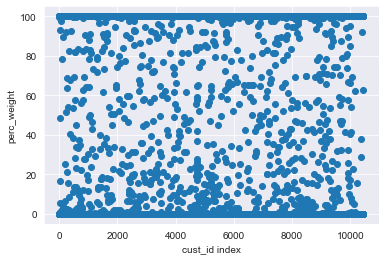

In [95]:
import pylab
#pylab.scatter(x, y)
perc_weight=mydf[['perc_weight']]
perc_prblsmore=mydf[['perc_prblsmore']]
pylab.scatter(perc_weight.index, perc_weight)
pylab.xlabel('cust_id index')
pylab.ylabel('perc_weight')

Text(0, 0.5, 'perc_prblsmore')

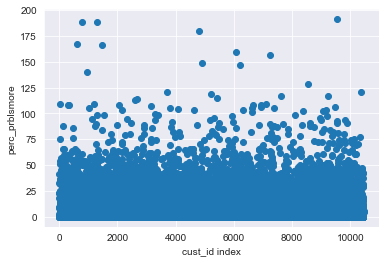

In [96]:
pylab.scatter(perc_prblsmore.index, perc_prblsmore)
pylab.xlabel('cust_id index')
pylab.ylabel('perc_prblsmore')

Text(0.5, 0, 'perc_weight')

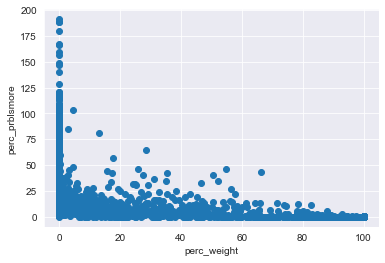

In [97]:
pylab.scatter(perc_weight,perc_prblsmore)
pylab.ylabel('perc_prblsmore')
pylab.xlabel('perc_weight')

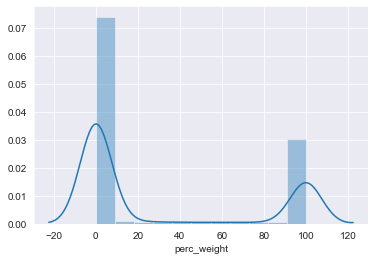

In [98]:
import seaborn as sns
sns.set_style('darkgrid')
sns.distplot(mydf['perc_weight'])

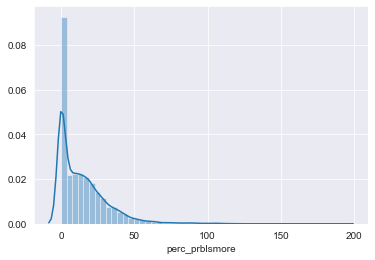

In [99]:
sns.distplot(mydf['perc_prblsmore'])

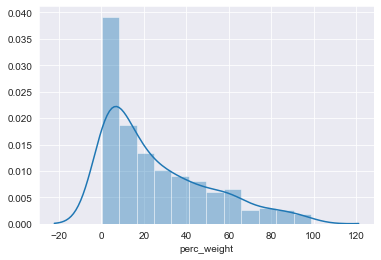

In [100]:
sns.set_style('darkgrid')
sns.distplot(mydf2['perc_weight'])

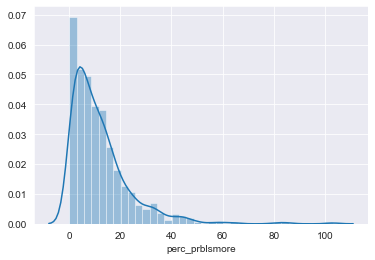

In [101]:
sns.distplot(mydf2['perc_prblsmore'])

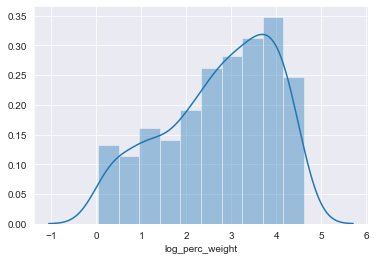

In [102]:
sns.set_style('darkgrid')
sns.distplot(mydf2['log_perc_weight'])

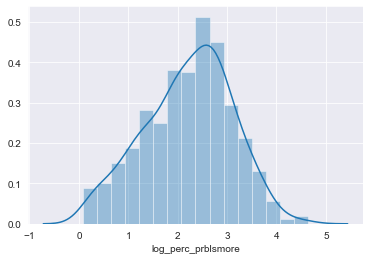

In [103]:
sns.distplot(mydf2['log_perc_prblsmore'])

In [104]:
from sklearn.preprocessing import StandardScaler
import numpy as np


scaler = StandardScaler()
scaled_data = scaler.fit_transform(mydf2.iloc[:,5:7].to_numpy())

scaled_perc_weight=scaled_data[:,0]
scaled_perc_prblsmore=scaled_data[:,1]
print("result of graph doesn't recommend this transformation")

result of graph doesn't recommend this transformation


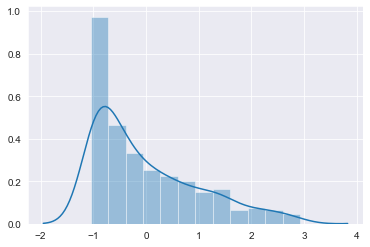

In [105]:
sns.distplot(scaled_perc_weight)

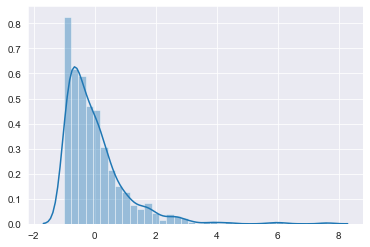

In [106]:
sns.distplot(scaled_perc_prblsmore)

In [107]:
from scipy import stats
normalized_data_0,_ = stats.boxcox(mydf2.iloc[:,5].to_numpy())  ###-->weight
normalized_data_1,_ = stats.boxcox(mydf2.iloc[:,6].to_numpy()+1)###-->prblsmore

print("comparing the graphs, recommend this transformation")

comparing the graphs, recommend this transformation


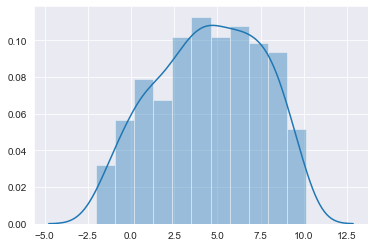

In [108]:
sns.distplot(normalized_data_0)

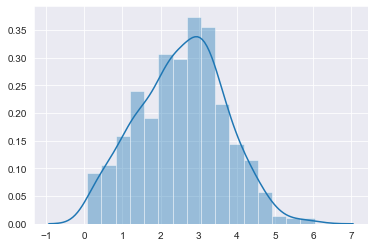

In [109]:
sns.distplot(normalized_data_1)

In [110]:
def finalizemydf2(mydf2):
    newdf=mydf2.drop(columns=['perc_weight', 'perc_prblsmore','log_perc_weight','log_perc_prblsmore'])
    newdf['perc_weight']=normalized_data_0
    newdf['perc_prblsmore']=normalized_data_1
    return newdf

In [111]:
mydf3=finalizemydf2(mydf2)
mydf3.head()

,cust_id,Total Paid Hours,weight,avg_pay,avg_H_MEDIAN,perc_weight,perc_prblsmore
25,1000004350,130823.81,7088.70,12.774449,15.398660,2.219029,3.642678
35,1000005773,66719.54,222.18,9.828270,13.338015,-0.938803,4.408339
42,1000006361,3724.30,42.96,13.922479,18.393537,0.142822,4.256634
44,1000006555,25010.41,4165.31,15.656898,16.519149,4.479573,2.077194
50,1000007991,1187.31,575.00,16.167913,16.381406,7.493987,0.881164


# clutering modeling and elbow graph after scaling data

In [112]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [113]:
def makecluster(orig_mydf, datax, cluster_count):
    kmeans = KMeans(cluster_count)
    kmeans.fit(datax)
    identified_clusters = kmeans.fit_predict(datax)
    mydf_with_clusters = orig_mydf.copy()
    mydf_with_clusters['Clusters'] = identified_clusters 
    cluster_result=mydf_with_clusters
    return cluster_result
    
def plotcluster(dfcluster):
    plt.scatter(dfcluster['perc_weight'], dfcluster['perc_prblsmore'], c=dfcluster['Clusters'],cmap='Set3')

    
def elbow(datax):
    rangeend=10
    wcss=[]
    for i in range(1,rangeend):
        kmeans= KMeans(i)
        kmeans.fit(datax)
        wcss_iter = kmeans.inertia_
        wcss.append(wcss_iter)

    number_clusters = range(1,rangeend)
    plt.plot(number_clusters,wcss)
    plt.title('Elbow Chart')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')

In [114]:
x = mydf.iloc[:,5:7]
cluster_result_x=makecluster(mydf,x,3)
cluster_result_x.head()

,cust_id,Total Paid Hours,weight,avg_pay,avg_H_MEDIAN,perc_weight,perc_prblsmore,log_perc_weight,log_perc_prblsmore,Clusters
0,1000000011,1389.70,0.0,15.056851,15.43985,0.0,2.54,0.000000,1.264127,1
1,1000002326,136.25,0.0,15.000000,19.90000,0.0,32.67,0.000000,3.516607,2
2,1000002366,6251.50,6251.5,15.333054,11.65000,100.0,0.00,4.615121,0.000000,0
3,1000002374,10494.50,0.0,11.000000,13.53000,0.0,23.00,0.000000,3.178054,1
4,1000002381,102.00,102.0,15.000000,13.66000,100.0,0.00,4.615121,0.000000,0


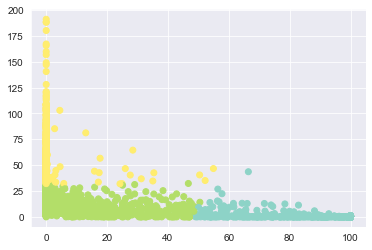

In [115]:
plotcluster(cluster_result_x)

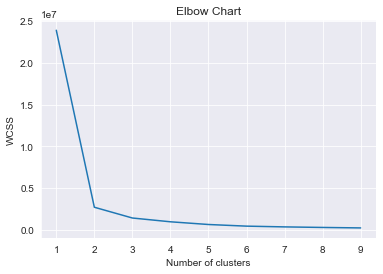

In [116]:
elbow(x)

In [117]:
xx = mydf3.iloc[:,5:7]
cluster_result_xx=makecluster(mydf3,xx,4)
cluster_result_xx.head()

,cust_id,Total Paid Hours,weight,avg_pay,avg_H_MEDIAN,perc_weight,perc_prblsmore,Clusters
25,1000004350,130823.81,7088.70,12.774449,15.398660,2.219029,3.642678,0
35,1000005773,66719.54,222.18,9.828270,13.338015,-0.938803,4.408339,3
42,1000006361,3724.30,42.96,13.922479,18.393537,0.142822,4.256634,3
44,1000006555,25010.41,4165.31,15.656898,16.519149,4.479573,2.077194,0
50,1000007991,1187.31,575.00,16.167913,16.381406,7.493987,0.881164,1


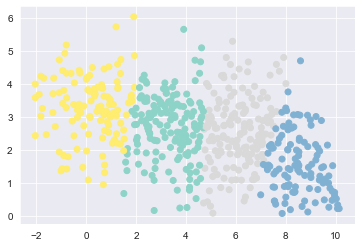

In [118]:
plotcluster(cluster_result_xx)

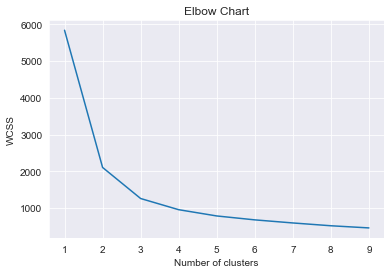

In [119]:
elbow(xx)

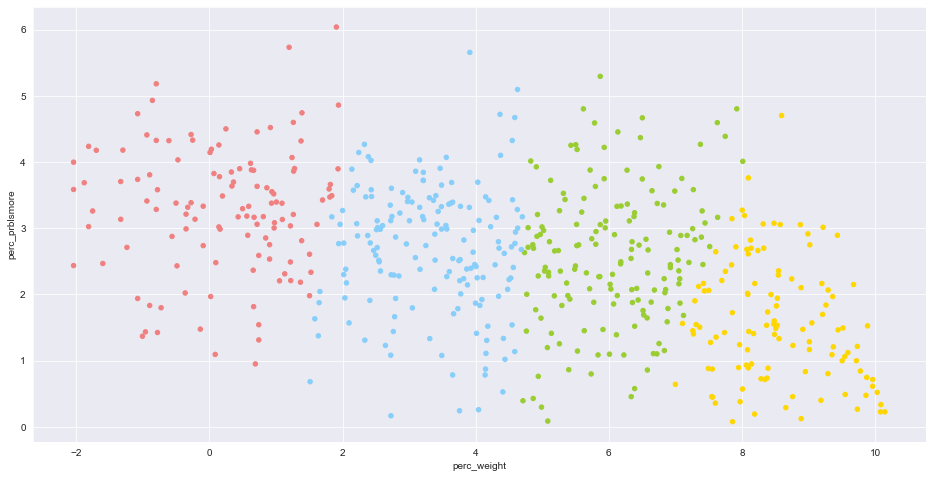

In [120]:
#customize colors so I know which is which category

LABEL_COLOR_MAP = {0 : 'lightskyblue',
                   1 : 'gold',
                   2 : 'yellowgreen',
                   3 : 'lightcoral'}


cluster_result_xx.plot(
        kind='scatter',
        x='perc_weight',y='perc_prblsmore',
        c=cluster_result_xx.Clusters.map(LABEL_COLOR_MAP), 
        figsize=(16,8))

In [169]:
# This can be set differently!!#

def tidyresults(df):
    #input df= cluster_result_xx
    
    df.loc[df['Clusters'] ==2 , 'decision'] = 0.80,
    df.loc[df['Clusters'] ==3 , 'decision'] = 0,
    df.loc[df['Clusters'] ==1 , 'decision'] = 0.50,
    df.loc[df['Clusters'] ==0 , 'decision'] = 0.20,
    df=df.drop(columns='Clusters')
    
    return df


In [170]:
prelim_decision=tidyresults(cluster_result_xx)
prelim_decision.head()

,cust_id,Total Paid Hours,weight,avg_pay,avg_H_MEDIAN,perc_weight,perc_prblsmore,decision
25,1000004350,130823.81,7088.70,12.774449,15.398660,2.219029,3.642678,0.2
35,1000005773,66719.54,222.18,9.828270,13.338015,-0.938803,4.408339,0.0
42,1000006361,3724.30,42.96,13.922479,18.393537,0.142822,4.256634,0.0
44,1000006555,25010.41,4165.31,15.656898,16.519149,4.479573,2.077194,0.2
50,1000007991,1187.31,575.00,16.167913,16.381406,7.493987,0.881164,0.5


# recovery calculation

In [171]:
def makefinaldecision(df1,df2):
    #df1=prelim_decision
    #df2=rest_of_df
    
    df2.loc[df2['perc_weight']>99, 'decision']=0
    df2.loc[df2['perc_weight']==0, 'decision']=0
    
    result=pd.concat([df1, df2], ignore_index=True)
    result=result.drop(columns=['perc_weight','perc_prblsmore', "weight"])
    
    return result

In [172]:
final_decision=makefinaldecision(prelim_decision,rest_of_df)
print(final_decision.shape)
final_decision.head()

(10376, 5)


,cust_id,Total Paid Hours,avg_pay,avg_H_MEDIAN,decision
0,1000004350,130823.81,12.774449,15.398660,0.2
1,1000005773,66719.54,9.828270,13.338015,0.0
2,1000006361,3724.30,13.922479,18.393537,0.0
3,1000006555,25010.41,15.656898,16.519149,0.2
4,1000007991,1187.31,16.167913,16.381406,0.5


In [173]:
cus_final.shape

(689791, 53)

In [174]:
def cust_recovery(cusfinal,jwtest,finaldecision):
    
    #input:
    #cusfinal=cust_final
    #finaldecision=final_decision
    #jwtest=jwtest
    
    
    #######df type/class_fix &&& geodata####
    cusfinal['cust_id'] = pd.to_numeric(cusfinal['cust_id'])
    finaldecision['cust_id'] = pd.to_numeric(finaldecision['cust_id'])
    jwtest['cust_id'] = pd.to_numeric(jwtest['cust_id'])
    jwtest['branch_code'] = pd.to_numeric(jwtest['branch_code'])
    
    geodata=cus_final[['cust_id','branch_code','STATE','CITY','POSTAL','ws_latitude','ws_longitude']]
    geodata['cust_id'] = pd.to_numeric(geodata['cust_id'])
    geodata['branch_code'] = pd.to_numeric(geodata['branch_code'])
    geodata=geodata.drop_duplicates()    
    
    ####------->>>>>>>>development of recovery based on cust_churn, tells cust, branch, job_OCC
    
    df=pd.merge(cusfinal,finaldecision,on='cust_id',how="inner")
    
    df['pr_vsmedian'] = df['pr_vsmedian'].apply(lambda x : x if x > 0 else 0)
    
    df["Net_recovery_perc"]=(df['pr_vsmedian']*df['decision']+df['avg_pay_rate'])/df['avg_pay_rate']-1
    
    df['recovery_amt']=df['total_billed_amt']*df["Net_recovery_perc"]
    

    ####------->>>>>>>>>development of recovery based on hyperion data
    
    prep_decision=finaldecision.copy()
    
    df_hyp=pd.merge(jwtest,prep_decision,on='cust_id',how="inner")
    
    df_hyp['pr_vsmedian'] = np.where(df_hyp['yesno'] != 1, 
                                     (df_hyp['WA_H_MEDIAN']-df_hyp['Average Regular Time Pay Rate']), 0)
        
    df_hyp["Net_recovery_perc"]=(df_hyp['pr_vsmedian']*df_hyp['decision']+df_hyp['Average Regular Time Pay Rate'])/df_hyp['Average Regular Time Pay Rate']-1
    

    df_hyp['recovery_amt']=df_hyp['Average Regular Time Bill Rate']*df_hyp["Net_recovery_perc"]*df_hyp['Total Paid Hours_x']  
    
    selected_vol=['cust_id', 'branch_code', 'Total Paid Hours_x', 'Gross Margin %', 'Average Regular Time Pay Rate',
                  'Average Regular Time Bill Rate', 'concept_desc', 'WA_H_MEDIAN', 'decision',  
                  'Net_recovery_perc', 'recovery_amt','STATE','CITY','POSTAL','ws_latitude','ws_longitude' ]
    
    df2=df_hyp.merge(geodata, on=['cust_id', 'branch_code'], how='inner') 
    df2 = df2.drop_duplicates(subset = ['cust_id', 'branch_code'], keep = 'last').reset_index(drop = True)
    
    df2=df2[selected_vol]
    
    return df, df2


df_cust_recovery, df_hyp_recovery=cust_recovery(cus_final, jwtest, final_decision)


In [175]:
df_cust_recovery['recovery_amt'].sum()

17803374.014832426

In [176]:
print(df_hyp_recovery.shape)
df_hyp_recovery['recovery_amt'].sum()

(14570, 16)


14316573.31565322

In [177]:
print("cust data comparison")
print(cus_final.shape)
print(df_cust_recovery.shape)

print("hype data comparison")
print(jwtest.shape)
print(df_hyp_recovery.shape)


cust data comparison
(689791, 53)
(686515, 59)
hype data comparison
(14656, 14)
(14570, 16)


In [178]:
#df_cust_recovery.head()

In [179]:
df_hyp_recovery.head()

,cust_id,branch_code,Total Paid Hours_x,Gross Margin %,Average Regular Time Pay Rate,Average Regular Time Bill Rate,concept_desc,WA_H_MEDIAN,decision,Net_recovery_perc,recovery_amt,STATE,CITY,POSTAL,ws_latitude,ws_longitude
0,2000931209,14388,256.00,0.052816,15.590000,29.980000,RIS,19.32,0.0,0.0,0.0,CA,SAN FRANCISCO,94108,37.788309,-122.404096
1,2000608974,14388,2782.00,0.370994,15.836130,30.963026,RIS,21.80,0.0,0.0,0.0,CA,SAN FRANCISCO,94108,37.788309,-122.404096
2,2001034584,26022,69.50,0.333377,15.000000,25.000000,MC,18.05,0.0,0.0,0.0,KY,LOUISVILLE,40204,38.235509,-85.709114
3,2001030715,18024,18.00,0.187843,17.333333,24.266667,MC,14.33,0.0,0.0,0.0,FL,MIAMI,33137,25.813049,-80.193652
4,2001030715,39058,2509.34,0.175988,13.085543,18.319764,MC,15.22,0.0,0.0,0.0,NJ,SECAUCUS,07094,40.763359,-74.066779


In [180]:
#df_cust_recovery.to_csv('tableau_df_cust_recovery.csv')

#df_hyp_recovery.to_csv('tableau_df_hyp_recovery.csv')